In [154]:
from cv2 import *
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf

In [155]:
import keras,os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD
from keras.models import Model
from keras import optimizers , layers, applications

In [156]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [157]:
filenames = os.listdir("/content/drive/MyDrive/AutismDataset/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

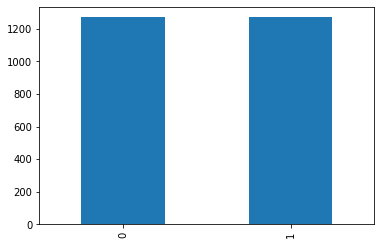

In [158]:
train_df['category'].value_counts().plot.bar()

In [159]:
test_filenames = os.listdir("/content/drive/MyDrive/AutismDataset/test")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

test_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [160]:
test_df.head()

,filename,category
0,Non_Autistic.216.jpg,0
1,Non_Autistic.1251.jpg,0
2,Non_Autistic.184.jpg,0
3,Non_Autistic.251.jpg,0
4,Non_Autistic.1116.jpg,0


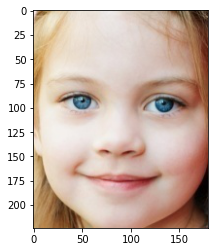

In [161]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/AutismDataset/train/"+sample)
plt.imshow(image)

In [162]:
image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 4
batch_size = 20

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [163]:

train_df, validate_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()


total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [164]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/AutismDataset/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2286 validated image filenames belonging to 2 classes.


In [165]:
# Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/AutismDataset/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 254 validated image filenames belonging to 2 classes.


In [166]:
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/4
114/114 [==============================] - 48s 398ms/step - loss: 0.6852 - accuracy: 0.5900 - val_loss: 0.4878 - val_accuracy: 0.8083
Epoch 2/4
114/114 [==============================] - 45s 395ms/step - loss: 0.5455 - accuracy: 0.7255 - val_loss: 0.3919 - val_accuracy: 0.8333
Epoch 3/4
114/114 [==============================] - 46s 400ms/step - loss: 0.5348 - accuracy: 0.7339 - val_loss: 0.4432 - val_accuracy: 0.8083
Epoch 4/4
114/114 [==============================] - 45s 396ms/step - loss: 0.4841 - accuracy: 0.7723 - val_loss: 0.4172 - val_accuracy: 0.8208


In [167]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.829167  ;  loss = 0.407583 


In [168]:
test_filenames = os.listdir("/content/drive/MyDrive/AutismDataset/test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [169]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/MyDrive/AutismDataset/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 300 validated image filenames.


In [170]:
threshold = 0.5
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

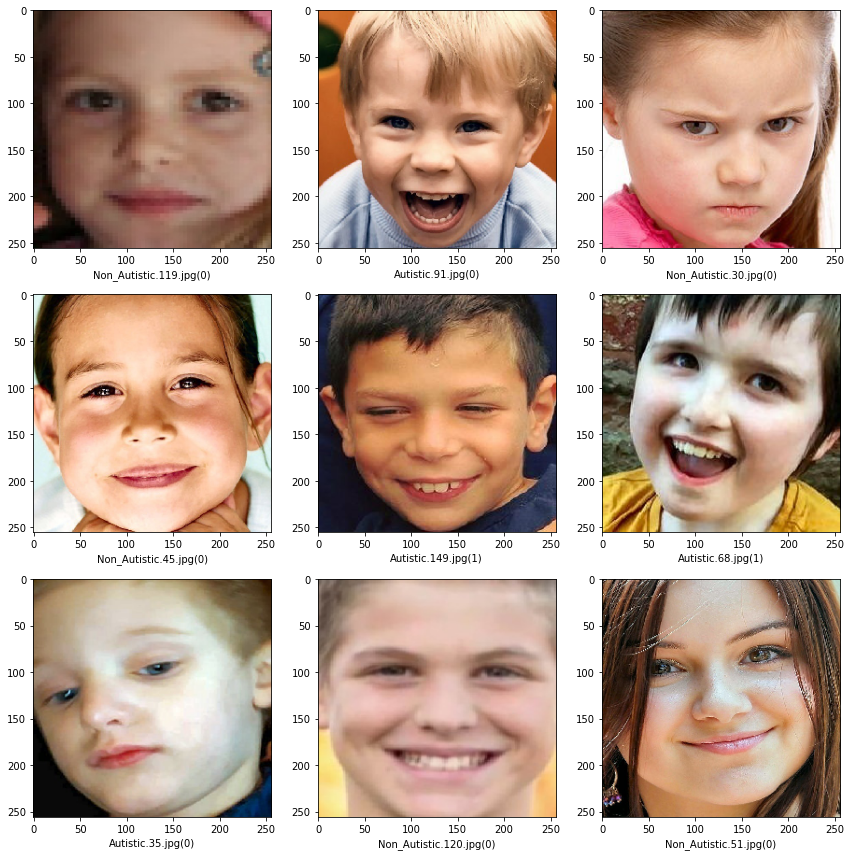

In [171]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/drive/MyDrive/AutismDataset/test/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   A1                   1054 non-null   int64 
 1   A2                   1054 non-null   int64 
 2   A3                   1054 non-null   int64 
 3   A4                   1054 non-null   int64 
 4   A5                   1054 non-null   int64 
 5   A6                   1054 non-null   int64 
 6   A7                   1054 non-null   int64 
 7   A8                   1054 non-null   int64 
 8   A9                   1054 non-null   int64 
 9   A10                  1054 non-null   int64 
 10  Age_Mons             1054 non-null   int64 
 11  Qchat-10-Score       1054 non-null   int64 
 12  Sex                  1054 non-null   object
 13  Ethnicity            1054 non-null   object
 14  Jaundice             1054 non-null   object
 15  Family_mem_with_ASD  1054 non-null   object
 16  Class/

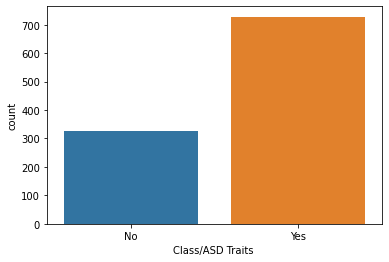

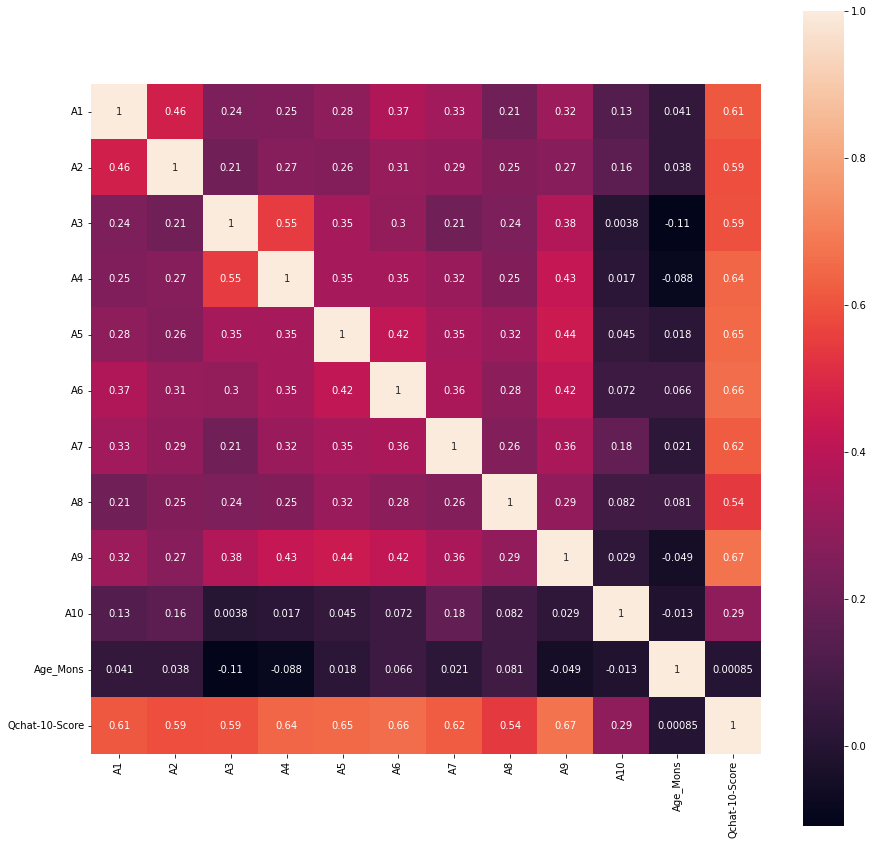

In [172]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler , StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, classification_report

asd = pd.read_csv("Toddler Autism dataset July 2018.csv")

asd.head()

asd.describe()

asd.drop(['Case_No', 'Who completed the test'], axis = 1, inplace = True)
asd.columns

sns.countplot(x='Class/ASD Traits ' , data=asd)

corr = asd.corr()
plt.figure(figsize = (15,15))
sns.heatmap(data = corr, annot = True, square = True, cbar = True)

asd.info()

In [173]:
le = LabelEncoder()
columns = ['Ethnicity', 'Family_mem_with_ASD', 'Class/ASD Traits ', 'Sex', 'Jaundice']
for col in columns:
    asd[col] = le.fit_transform(asd[col])

X = asd.drop(['Class/ASD Traits '], axis = 1)
Y = asd['Class/ASD Traits ']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 7)

SVM_model = SVC()
SVM_model.fit(x_train, y_train)
pred = SVM_model.predict(x_test)
classification_report(y_test,pred)

accuracy_score(y_test, pred)

0.981042654028436

In [174]:
x_test.head(2)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Age_Mons,Qchat-10-Score,Sex,Ethnicity,Jaundice,Family_mem_with_ASD
650,0,0,1,1,0,1,0,0,0,1,24,4,1,6,0,0
34,0,0,0,0,0,0,0,0,0,1,12,1,0,8,0,0


In [175]:
def prediction(url,feature_list):
  #for image
  img = tf.keras.preprocessing.image.load_img(url,target_size=(224,224,2))
  img_nparray = tf.keras.preprocessing.image.img_to_array(img)
  input_Batch = np.array([img_nparray])  
  predictions = model.predict(input_Batch)
  #for the features
  arr = np.array(feature_list)
  arr = arr.reshape(1,16)
  res = SVM_model.predict(arr)
  if predictions > 0.5 and res == 1:
    print("Autistic")
  else:
    print("Non Autistic")

In [176]:
url = "/content/drive/MyDrive/AutismDataset/test/Autistic.123.jpg"
feature_list = [[0],[0],[0],[0],[1],[0],[0],[1],[1],[0],[12],[0],[0],[1],[1],[1]]
res = prediction(url,feature_list)

Non Autistic
